## Testing algorithms for tweet_data class.

Algorithm below initialises dense time series for correlation testing.  If 'use fixed means for setup' is True then the two populations created have expected proportions of entries given by the 'means' dictionary list.  Otherwise each time series within both populations has an expected proportion of entries given by a random selection from a truncated chai-squared distribution.  If poisson_process is true then a poisson process is used to initialise.
The two populations of time series are returned in an array; the known probability from which each individual time series was drawn are stored are also returned as an array 

In [13]:
import time
import numpy as np
import poisson_processes as pp
import pointwise_correlation as pc

def initialise_time_series_matrices(length,number,use_fixed_means_for_setup=True,means=[0.01,0.2],poisson_process=False,verbose=True):
    T=length
    n=number
    if verbose:
        print("Now initialising externally")
    if use_fixed_means_for_setup:
        print("Initialising with fixed means")
        known_probs_array = [[p for i in range(n)] for p in means]
    else:
        print("Initialising with chi square dist")
        ps=[[np.random.chisquare(6)/30 for i in range(n)] for j in range(2)]
        known_probs_array=[[p if (p and p<1) else np.random.uniform(0.1,0.3) for p in vector] for vector in ps]
        
    
    if poisson_process:
        Y1_lambdas = [1/p for p in known_probs_array[0]]
        Y2_lambdas = [1/p for p in known_probs_array[1]]
        if verbose:
            print("Initialising using poisson process")
        lambdas = {'Y1': {'lambda':Y1_lambdas,'baseline':False},
                'Y2': {'lambda':Y2_lambdas,'baseline':False}
                  }
        ts = pp.poisson_process(number = n, length = T, lambdas = lambdas).ts_dict
        tweet_matrices=np.array([ts[key] for key in ts.keys()])


        p1=np.sum([len(x) for x in tweet_matrices[0]])/(number*length)
        print(p1)
        p2=np.sum([len(x) for x in ts['Y2']])/(number*length)
        print(p2)
        means=[p1,p2]
        known_probs_array = [[p for i in range(n)] for p in means]
                   
        return tweet_matrices,known_probs_array
    
                   
                   
#    if use_fixed_means_for_setup:
    
#        tweet_matrices=[[np.random.choice(range(T),size=int(np.random.normal(T*p,np.sqrt(T*p*(1-p)))),replace=False) \
 #                        for i in range(n)] for p in means]
        

            
    else:

#
        tweet_matrices=[[np.random.choice(range(T),size=int(np.random.normal(T*p,np.sqrt(T*p*(1-p)))),replace=False)\
                              for p in vector] for vector in known_probs_array]

    return tweet_matrices, known_probs_array

In [2]:
print(initialise_time_series_matrices(1000,20,poisson_process =True))

Now initialising externally
Initialising with fixed means
Initialising using poisson process
Initialising for key Y1
Elapsed time: 0.010009527206420898
Initialising for key Y2
Elapsed time: 0.038930416107177734
(array([[array([127, 165, 172, 187, 193, 231, 358, 754, 852, 954]),
        array([ 41, 108, 167, 181, 338, 477, 523, 853, 993]),
        array([ 96, 147, 222, 399, 456, 810, 996]),
        array([ 16,  75, 102, 233, 291, 495, 878, 906, 952]),
        array([267, 500, 639, 684, 877, 881, 898]),
        array([ 91, 182, 534, 566, 703, 711, 740, 836]),
        array([ 15,  35,  41,  83, 136, 169, 234, 278, 345, 359, 372, 401, 502,
       511, 676, 700, 705, 715, 723, 771]),
        array([ 79, 169, 260, 307, 410, 554, 662, 809, 856]),
        array([ 28,  94, 152, 158, 657, 841, 850, 852, 958, 959, 989]),
        array([184, 190, 243, 379, 474, 512, 581, 681, 746, 813, 884, 937, 955]),
        array([ 42, 437, 547, 552, 596, 794, 838, 900, 984]),
        array([  2,  52,  95, 134,

Algorithm tests the two sigma calculations (designated by inferred/known means).   A random set(s) of time series is created (by the tweet_data class method) and correlation z-scores calculated for all pairs of time series.  If disjoint=True, two populations are created and compared pairwise.  If disjoint=False, all pairs within a single population are compared.  Delta is fixed at sqrt(length of time series) but multiple lengths can be passed if required and the test will be carried out for each, with results plotted using both sigma calculations.  Overall results are plotted cumulatively with the final set of graphs contatining all data throughout.

Population means can be fixed in advance (if 'Use fixed means for setup' matches true in the parameter dictionary), or taken from a truncated chai squared distribution if not. 'Use population means is true initially so the later version of sigma is used in this first pass for each length of time series passed.  'Use population means' is then set to false allowing a run on the same data but using each individual time series to estimate the mean in the population from which it was taken.

In [14]:
import time

def compare_inferred_and_known_means(version,xs=[100,200],params=[0.1,0.5,{}],poisson_process=False,disjoint=True,verbose=False,axes=[]):
    """
    *Compares z_scores when means are inferred/known
    *Plot of sigma values for each against length of time series (given by parameter xs) is also shown
    *Number of time series given by parameter number (either in one or both populations)
    *If parameter disjoint is True, two separate populations are tested against each other pairwise
    *If disjoint is False, only one population is tested but all possible pairings are formed
    *If probs are None, individual probabilities are taken from a chai squared distribution
    """
    params_dict = params[2]
    params_dict['p1'] = params[0]
    params_dict['p2'] = params[1]
    use_external_initialisation = params_dict['Use external intialisation']
    number=params_dict['n']
    ts=[]
    ys = [] # sigma values for z scores based on inferred means
    zs =[] # mean values for z scores based on inferred means
    y1s=[] # sigma values for z scores based on known population means
    z1s=[] #sigma values for z scores based on known population means
    start_time = time.time()
    
    # start run - for each length of time series (in array xs) correlations are measured for both sigma values
    for T in xs:
        # use maximum delta value
        delta = int(np.sqrt(T)) 
        ts.append(T)        
        print("T is {0}".format(T))

        # set up axes to display results
        f,axes = plt.subplots(2,2)
        f.suptitle("Comparison of inferred v known population means for T = {0},delta = {1}".format(T,delta),fontsize=16)
        for ax in axes[0]:
            ax.plot([0,1],[0,0],'.',alpha=0.2)
        for ax in axes[1]:
            ax.plot([-2,2],[0,0],'.',alpha=0.2)
            
        # initialise time series if using algorithm in notebook
        if use_external_initialisation:
            tweet_matrices,known_probs_array = initialise_time_series_matrices(T,number,use_fixed_means_for_setup=params[2]['Use fixed means for setup'],\
                                                          means=[params[0],params[1]],poisson_process=poisson_process,verbose=verbose)
            # create time series objects for each time series
            ts_matrices=[[pc.time_series(tweet_matrices[i][j],known_probs_array[i][j],T) for j in range(number)] 
                             for i in range(len(tweet_matrices))]
 
        else:
            ts_matrices = [] # will be initialised within the class
            
        # set parameters and instantiate classes
        params_dict['T'] = T
        if version == pc:
            td = version.tweet_data(ts_matrices,params_dict,delta = delta,
                        disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
        else:
            td = version.tweet_data(tweet_matrices=ts_matrices,population_ps = [params[0],params[1],params_dict],delta = delta,
                        disjoint_sets=disjoint,verbose=verbose,axes = [axes[0][0],axes[1][0]])
 
        
        print("Running with inferred means.  Time elapsed: {0}".format(time.time()-start_time))        
        params_dict['Use population means']=False
        td.population_ps=[params[0],params[1],params_dict]

        td.display_Z_vals()
        ys.append(np.std(td.results))
        zs.append(np.mean(td.results))
        
        
        params_dict['Use population means']=True
        td.population_ps=[params[0],params[1],params_dict]
        td.axes=[axes[0][1],axes[1][1]]
        print("Running with population means. Time elapsed: {0}".format(time.time()-start_time))
        
        td.display_Z_vals()
        y1s.append(np.std(td.results))
        z1s.append(np.mean(td.results))
        #pd.DataFrame(np.transpose([ts,zs,ys,z1s,y1s])).to_csv("{0}/Accumulating results.csv".format(TEMP_DIR))
    
        axes[0][1].errorbar(ts,zs,ys,color='r',label='inferred')
        axes[0][1].errorbar(ts,z1s,y1s,color='b',label='known')
        axes[0][1].set_title("Accumulating results")
        axes[0][1].legend()
        axes[1][0].legend()
        axes[1][1].legend()
        
        plt.show()
    df=pd.concat([pd.DataFrame(xs,columns=['T']),
                   pd.DataFrame(ys,columns=['Z score std dev (inferred means)']),
                   pd.DataFrame(zs,columns=['Z score mean (inferred means)']),
                   pd.DataFrame(y1s,columns=['Z score std dev (known means)']),
                   pd.DataFrame(z1s,columns=['Z score mean (known means)'])],axis=1)
    #df.to_csv("{0}/Sigma_comparison{1}.csv".format(TEMP_DIR,str(xs)[:10]),mode='a')
    return df

The cell below runs the algorithm above, passing the version of the tweet_data class using the 'version' parameter. pointwise_correlation.py code is more streamlined than time_series_correlation.py

T is 10000
Now initialising externally
Initialising with fixed means
Initialising using poisson process
Initialising for key Y1
Elapsed time: 1.6545732021331787
Initialising for key Y2
Elapsed time: 9.23333477973938
0.00994486
0.04879524
Analysis of tweet matrix 0: 5000 time series length 10000
Analysis of tweet matrix 1: 5000 time series length 10000
Running with inferred means.  Time elapsed: 9.961421489715576
0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,Sample mean -0.001024040806898148, sample sigma 0.9842329633352308
Delta (max time-lag tested)

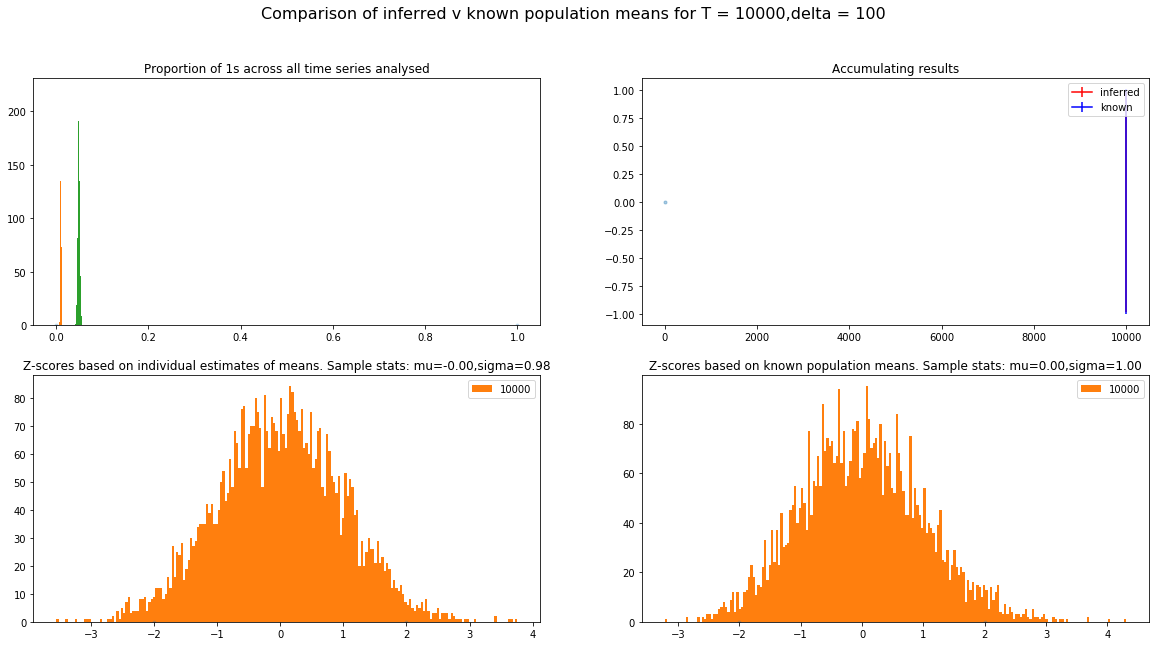

,T,Z score std dev (inferred means),Z score mean (inferred means),Z score std dev (known means),Z score mean (known means)
0,10000,0.984233,-0.001024,1.001591,0.000067


Total of 0 empty time series found
Total of 0 time series calculations ignored (due to fewer than 4 events in one or both)


In [15]:
import pointwise_correlation as pc
import time_series_correlation as tc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize']=[20,10]

pc.SHORT_TIME_SERIES_Z_SCORES = []
pc.EMPTY_TIME_SERIES_COUNT = 0
# parameter dictionary 
params_dict = {
#                'T' : 1000                        # Length of each time series
                'n' : 5000,                      # How many time series in each population
               'Use external intialisation' : True,
#                   'Use population means' : True, # Refers to whether correlation calculation is based on pre-determined or measured means
                   'Use fixed means for setup' : True, # Refers to whether population(s) taken from given means or chai-squared dist
#                       'random seed' : None,
#                   'Test_mode' : False,
                   'dense' : True,  # only needed for time_series_correlation (obsolete class)
                    'sparse': False # must be false - only dense time series can be analysed
                    } 

lengths=[10000]  # Which lengths of time series to run the algorithm for
p1=0.01                # mean occurences from which populations will be drawn 
p2=0.05                # if fixed means are used
df=compare_inferred_and_known_means(version=pc,xs=lengths,params=[p1,p2,params_dict],
                                    poisson_process=True,disjoint=True,verbose=True)
plt.show()
display(df)

short_ts_data = np.array(pc.SHORT_TIME_SERIES_Z_SCORES)
print("Total of {0} empty time series found".format(pc.EMPTY_TIME_SERIES_COUNT))
print("Total of {0} time series calculations ignored (due to fewer than 4 events in one or both)".format(len(short_ts_data)))

if len(short_ts_data):
    df = pd.DataFrame(list(np.transpose([[min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],list(short_ts_data[:,2])])),
                      columns = ['Length of short time series','Z score'])
    print("Z_scores for comparisons involving very short series averaged : {0}".format(np.mean(short_ts_data[:,2])))
    #plt.plot([min(ts_data[0],ts_data[1]) for ts_data in short_ts_data],short_ts_data[:,2], 'x')
    #plt.show()

#print("Mean and sigma for the z scores for empty time series are {0} and {1}".format(np.mean(z_scores), np.std(z_scores)))
#plt.hist(z_scores)
